In [1]:
#  imports + dataset path 
from pathlib import Path
import os
from collections import Counter
from sklearn.model_selection import train_test_split
import shutil

 
DATA_ROOT = Path("/kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage")

# sanity check
print("DATA_ROOT:", DATA_ROOT)
print("Exists:", DATA_ROOT.exists())
print("Number of items in DATA_ROOT:", len(list(DATA_ROOT.iterdir())))


DATA_ROOT: /kaggle/input/plantvillage-tomato-leaf-dataset/plantvillage/plantvillage
Exists: True
Number of items in DATA_ROOT: 10


In [2]:
# class list and counts
 
class_dirs = [p for p in sorted(DATA_ROOT.iterdir()) if p.is_dir()]
classes = [p.name for p in class_dirs]

# count images per class
counts = {}
for p in class_dirs:
    counts[p.name] = len(list(p.glob("**/*")))

print("Found classes ({}):".format(len(classes)))
for c in classes:
    print(f"  {c}: {counts[c]} files")


Found classes (10):
  Tomato___Bacterial_spot: 1702 files
  Tomato___Early_blight: 800 files
  Tomato___Late_blight: 1527 files
  Tomato___Leaf_Mold: 761 files
  Tomato___Septoria_leaf_spot: 1417 files
  Tomato___Spider_mites Two-spotted_spider_mite: 1341 files
  Tomato___Target_Spot: 1123 files
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 4286 files
  Tomato___Tomato_mosaic_virus: 299 files
  Tomato___healthy: 1273 files


In [ ]:
#   split  
 
OUT_ROOT = Path("/kaggle/working/data")
train_dir = OUT_ROOT / "train"
val_dir   = OUT_ROOT / "val"
test_dir  = OUT_ROOT / "test"

# create folders  
for d in (train_dir, val_dir, test_dir):
    d.mkdir(parents=True, exist_ok=True)

# collect  all items (filepath, label)
items = []
for cls_dir in class_dirs:
    for img in cls_dir.glob("*"):
        if img.is_file():
            items.append((str(img), cls_dir.name))

# prepare lists
filepaths = [i[0] for i in items]
labels    = [i[1] for i in items]

# first split: train vs temp  
fp_train, fp_temp, y_train, y_temp = train_test_split(
    filepaths, labels, stratify=labels, test_size=0.30, random_state=42)

# second split: temp -> val (15%) and test (15%)   
fp_val, fp_test, y_val, y_test = train_test_split(
    fp_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

# helper to copy files into class subfolders
def copy_to_subset(filepaths, labels, subset_root):
    for fp, lbl in zip(filepaths, labels):
        dest_dir = subset_root / lbl
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest_path = dest_dir / Path(fp).name
        if not dest_path.exists():
            shutil.copy(fp, dest_path)

# copy files
copy_to_subset(fp_train, y_train, train_dir)
copy_to_subset(fp_val,   y_val,   val_dir)
copy_to_subset(fp_test,  y_test,  test_dir)

# print summary counts after split
def counts_in(root):
    d = {}
    for c in sorted(classes):
        p = root / c
        d[c] = len(list(p.glob("*"))) if p.exists() else 0
    return d

print("Split summary (number of files per subset):")
print("  train total:", sum(counts_in(train_dir).values()))
print("  val   total:", sum(counts_in(val_dir).values()))
print("  test  total:", sum(counts_in(test_dir).values()))

print("\nPer-class counts in train (class:count):")
for k,v in counts_in(train_dir).items():
    print(f"  {k}: {v}")


Split summary (number of files per subset):
  train total: 10170
  val   total: 2179
  test  total: 2180

Per-class counts in train (class:count):
  Tomato___Bacterial_spot: 1191
  Tomato___Early_blight: 560
  Tomato___Late_blight: 1069
  Tomato___Leaf_Mold: 533
  Tomato___Septoria_leaf_spot: 992
  Tomato___Spider_mites Two-spotted_spider_mite: 939
  Tomato___Target_Spot: 786
  Tomato___Tomato_Yellow_Leaf_Curl_Virus: 3000
  Tomato___Tomato_mosaic_virus: 209
  Tomato___healthy: 891


Found 10170 files belonging to 10 classes.
Found 2179 files belonging to 10 classes.
Found 2180 files belonging to 10 classes.
Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']
Train batches: 318 | Train samples (approx): 10 (per-class counts visible earlier)
Val batches: 69 Test batches: 69


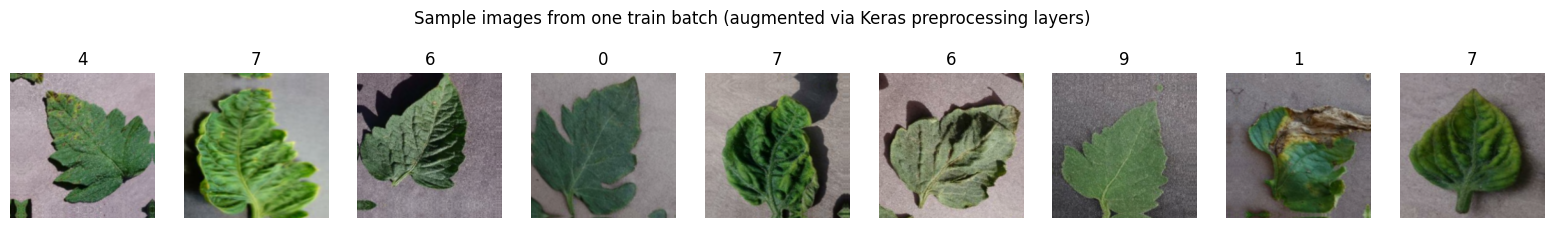

Batch stats: min,max,mean on sample batch: 0.0 0.9818673729896545 0.42093902826309204
Aug 1: min=0.000000, max=0.821782, mean=0.506752
Aug 2: min=0.000000, max=0.807882, mean=0.505720
Aug 3: min=0.000000, max=0.797878, mean=0.514030
Aug 4: min=0.000000, max=0.814597, mean=0.511624
Aug 5: min=0.000000, max=0.786989, mean=0.525733
Aug 6: min=0.000000, max=0.787929, mean=0.533522


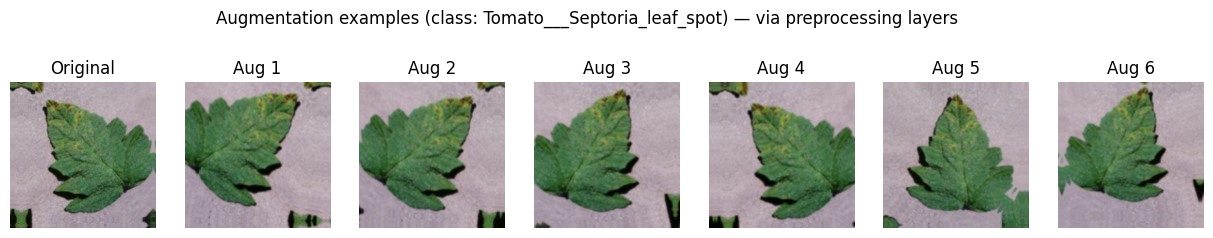

In [ ]:
#  augmentation  
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# GPU memory growth  
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for g in gpus:
            tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# settings
BATCH_SIZE = 32
TARGET_SIZE = (227, 227)   # AlexNet-style
TRAIN_DIR = "/kaggle/working/data/train"
VAL_DIR   = "/kaggle/working/data/val"
TEST_DIR  = "/kaggle/working/data/test"
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

#   create datasets from directory 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='categorical',
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy(),
      "| Train samples (approx):", len(class_names), "(per-class counts visible earlier)")
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy(),
      "Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

#  augmentation pipeline using  
 
normalization_layer = layers.Rescaling(1./255)

# augmentation pipeline 
augmentation_layer = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.12),        
    layers.RandomTranslation(0.08, 0.08),  
    layers.RandomZoom(0.08),
    layers.RandomContrast(0.08),
], name="augmentation")

# function to apply preprocessing 
def preprocess(images, labels, training=False):
    images = tf.cast(images, tf.float32)
    images = normalization_layer(images)
    if training:
        images = augmentation_layer(images, training=True)   
    return images, labels

# prepare dataset pipelines with caching/prefetch
train_ds = train_ds.map(lambda x,y: preprocess(x,y, training=True), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: preprocess(x,y, training=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_ds  = test_ds.map(lambda x,y: preprocess(x,y, training=False), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

# helper to make displayable uint8 [0,255]
def to_displayable_uint8(img_tensor):
    img = tf.clip_by_value(img_tensor, 0.0, 1.0)
    img = tf.cast(img * 255.0, tf.uint8)
    return img.numpy()

#  show one sample batch from train 
for batch_images, batch_labels in train_ds.take(1):
    imgs = batch_images.numpy()   
    labs = batch_labels.numpy()
    break

n_show = min(9, imgs.shape[0])
fig, axs = plt.subplots(1, n_show, figsize=(n_show*2.2, 2.8))
for i in range(n_show):
    axs[i].imshow(to_displayable_uint8(imgs[i]))
    axs[i].axis('off')
    axs[i].set_title(np.argmax(labs[i]))
plt.suptitle("Sample images from one train batch (augmented via Keras preprocessing layers)")
plt.show()

# print min/max/mean of that batch to confirm not all-zero
print("Batch stats: min,max,mean on sample batch:",
      float(imgs.min()), float(imgs.max()), float(imgs.mean()))

#  augmentation examples for one real image  
 
single = imgs[0:1]   
n_aug = 6
fig, axs = plt.subplots(1, n_aug+1, figsize=((n_aug+1)*2.2, 3))
axs[0].imshow(to_displayable_uint8(single[0]))
axs[0].set_title("Original")
axs[0].axis('off')
for i in range(1, n_aug+1):
    aug = augmentation_layer(single, training=True)  
    aug_img = aug[0]
    axs[i].imshow(to_displayable_uint8(aug_img))
    axs[i].set_title(f"Aug {i}")
    axs[i].axis('off')
   
    print(f"Aug {i}: min={float(aug_img.numpy().min()):.6f}, max={float(aug_img.numpy().max()):.6f}, mean={float(aug_img.numpy().mean()):.6f}")
plt.suptitle(f"Augmentation examples (class: {class_names[np.argmax(labs[0])]}) — via preprocessing layers")
plt.show()

 


In [ ]:
# AlexNet model 
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

 
try:
    NUM_CLASSES = len(class_names)
except NameError:
    NUM_CLASSES = 10    

INPUT_SHAPE = (227, 227, 3)
L2 = 1e-4

def build_alexnet(input_shape=INPUT_SHAPE, n_classes=NUM_CLASSES, l2=L2):
    inp = layers.Input(shape=input_shape)

    # 1st conv
    x = layers.Conv2D(96, (11,11), strides=4, padding='same', kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2)(x)

    # 2nd conv
    x = layers.Conv2D(256, (5,5), padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2)(x)

    # 3rd,4th,5th conv
    x = layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(384, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3,3), strides=2)(x)

    # FC heads
    x = layers.Flatten()(x)
    x = layers.Dense(4096, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(4096, kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    out = layers.Dense(n_classes, activation='softmax')(x)

    return models.Model(inputs=inp, outputs=out, name='AlexNet_like')

# build & compile
model = build_alexnet()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# print summary  
model.summary()


Model: "AlexNet_like"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 57, 57, 96)     │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 57, 57, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 13, 13, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4096)           │        16,384 │
│ (BatchNormalization)            │                        │             

 Total params: 58,356,490 (222.61 MB)

 Trainable params: 58,339,402 (222.55 MB)

 Non-trainable params: 17,088 (66.75 KB)

Epoch 1/50


I0000 00:00:1764165508.365885     170 service.cc:148] XLA service 0x40178390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764165508.367365     170 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764165508.367391     170 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764165509.251051     170 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/318 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.1016 - loss: 3.9781   

I0000 00:00:1764165518.412893     170 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5820 - loss: 2.4455
Epoch 1: val_loss improved from inf to 9.66269, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 90s 235ms/step - accuracy: 0.5823 - loss: 2.4444 - val_accuracy: 0.2226 - val_loss: 9.6627 - learning_rate: 1.0000e-04
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7819 - loss: 1.7591
Epoch 2: val_loss improved from 9.66269 to 3.09728, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 65s 204ms/step - accuracy: 0.7819 - loss: 1.7589 - val_accuracy: 0.5530 - val_loss: 3.0973 - learning_rate: 1.0000e-04
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8276 - loss: 1.5837
Epoch 3: val_loss did not improve from 3.09728
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - accuracy: 0.8276 - loss: 1.5835 - val_accuracy: 0.2721 - val_loss: 8.9205 - learning_rate: 1.0000e-04
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8489 - loss: 1.5020
Epoch 4: val_loss did not improve from 3.09728
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - accuracy: 0.8489 - loss: 1.5018 - val_accuracy: 0.5649 - val_loss: 3.3710 - learning_rate: 1.0000e-04
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8801 - loss: 1.3818
Epoch 5: val_loss improved from 3.09728 to 2.27517, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.8801 - loss: 1.3817 - val_accuracy: 0.6980 - val_loss: 2.2752 - learning_rate: 1.0000e-04
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8912 - loss: 1.3320
Epoch 6: val_loss improved from 2.27517 to 1.73402, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 65s 202ms/step - accuracy: 0.8912 - loss: 1.3320 - val_accuracy: 0.7857 - val_loss: 1.7340 - learning_rate: 1.0000e-04
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8917 - loss: 1.2982
Epoch 7: val_loss improved from 1.73402 to 1.60597, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 65s 203ms/step - accuracy: 0.8917 - loss: 1.2982 - val_accuracy: 0.8063 - val_loss: 1.6060 - learning_rate: 1.0000e-04
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9045 - loss: 1.2462
Epoch 8: val_loss improved from 1.60597 to 1.59058, saving model to /kaggle/working/models/alexnet_best.h5


318/318 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - accuracy: 0.9045 - loss: 1.2462 - val_accuracy: 0.8229 - val_loss: 1.5906 - learning_rate: 1.0000e-04
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9081 - loss: 1.1988
Epoch 9: val_loss did not improve from 1.59058
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - accuracy: 0.9081 - loss: 1.1988 - val_accuracy: 0.6631 - val_loss: 2.6363 - learning_rate: 1.0000e-04
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9198 - loss: 1.1616
Epoch 10: val_loss did not improve from 1.59058
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - accuracy: 0.9198 - loss: 1.1616 - val_accuracy: 0.2497 - val_loss: 7.1343 - learning_rate: 1.0000e-04
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9193 - loss: 1.1332
Epoch 11: val_loss did not improve from 1.59058

Epoch 11: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 197ms/step - accuracy: 0.9193 - loss

318/318 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - accuracy: 0.9479 - loss: 1.0309 - val_accuracy: 0.9027 - val_loss: 1.1830 - learning_rate: 5.0000e-05
Epoch 13/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9555 - loss: 0.9906
Epoch 13: val_loss did not improve from 1.18298
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 192ms/step - accuracy: 0.9555 - loss: 0.9906 - val_accuracy: 0.8118 - val_loss: 1.6264 - learning_rate: 5.0000e-05
Epoch 14/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9568 - loss: 0.9686
Epoch 14: val_loss did not improve from 1.18298
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - accuracy: 0.9568 - loss: 0.9686 - val_accuracy: 0.8779 - val_loss: 1.2651 - learning_rate: 5.0000e-05
Epoch 15/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9656 - loss: 0.9331
Epoch 15: val_loss did not improve from 1.18298

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - accuracy: 0.9656 - lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 64s 200ms/step - accuracy: 0.9678 - loss: 0.9064 - val_accuracy: 0.9720 - val_loss: 0.8865 - learning_rate: 2.5000e-05
Epoch 17/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9670 - loss: 0.8949
Epoch 17: val_loss did not improve from 0.88651
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - accuracy: 0.9670 - loss: 0.8949 - val_accuracy: 0.7719 - val_loss: 1.9094 - learning_rate: 2.5000e-05
Epoch 18/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9739 - loss: 0.8658
Epoch 18: val_loss did not improve from 0.88651
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 194ms/step - accuracy: 0.9739 - loss: 0.8658 - val_accuracy: 0.9399 - val_loss: 0.9585 - learning_rate: 2.5000e-05
Epoch 19/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9677 - loss: 0.8742
Epoch 19: val_loss did not improve from 0.88651

Epoch 19: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 196ms/step - accuracy: 0.9677 - lo

318/318 ━━━━━━━━━━━━━━━━━━━━ 64s 199ms/step - accuracy: 0.9787 - loss: 0.8257 - val_accuracy: 0.9725 - val_loss: 0.8491 - learning_rate: 1.2500e-05
Epoch 22/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9813 - loss: 0.8162
Epoch 22: val_loss did not improve from 0.84908
318/318 ━━━━━━━━━━━━━━━━━━━━ 62s 193ms/step - accuracy: 0.9813 - loss: 0.8162 - val_accuracy: 0.8591 - val_loss: 1.4029 - learning_rate: 1.2500e-05
Epoch 23/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9808 - loss: 0.8074
Epoch 23: val_loss did not improve from 0.84908
318/318 ━━━━━━━━━━━━━━━━━━━━ 63s 195ms/step - accuracy: 0.9808 - loss: 0.8073 - val_accuracy: 0.9013 - val_loss: 1.1338 - learning_rate: 1.2500e-05
Epoch 24/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9823 - loss: 0.7968
Epoch 24: val_loss did not improve from 0.84908

Epoch 24: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
318/318 ━━━━━━━━━━━━━━━━━━━━ 61s 191ms/step - accuracy: 0.9823 - los

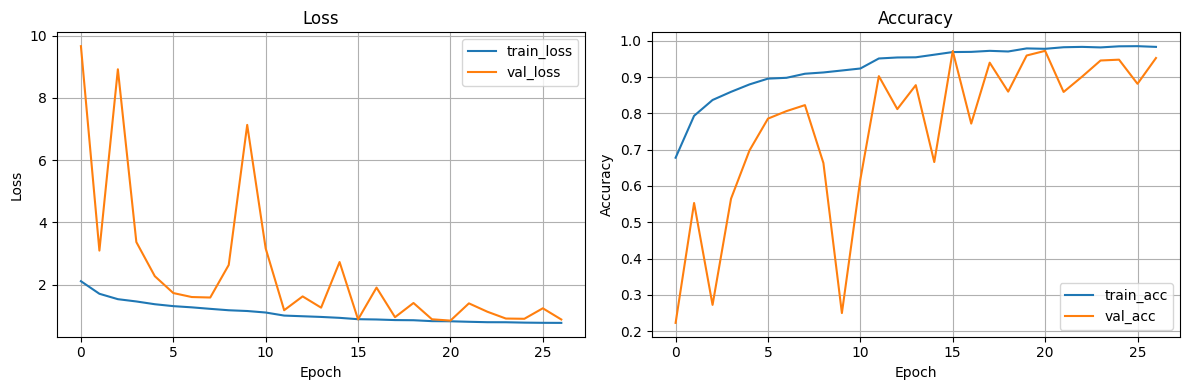

Best model saved to: /kaggle/working/models/alexnet_best.h5
Training history saved to: /kaggle/working/models/history.json


In [ ]:
#   Train AlexNet with tf.data  

import os
import json
import matplotlib.pyplot as plt
import tensorflow as tf

# Settings
EPOCHS = 50
PATIENCE = 6
MODEL_DIR = "/kaggle/working/models"
os.makedirs(MODEL_DIR, exist_ok=True)

BEST_PATH = f"{MODEL_DIR}/alexnet_best.h5"
HISTORY_PATH = f"{MODEL_DIR}/history.json"

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        BEST_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
]

# -------- TRAIN --------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

# Save history
hist_dict = history.history
with open(HISTORY_PATH, "w") as f:
    json.dump(hist_dict, f)

# -------- PLOT --------
def plot_history(h):
    plt.figure(figsize=(12,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(h["loss"], label="train_loss")
    plt.plot(h["val_loss"], label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(h["accuracy"], label="train_acc")
    plt.plot(h["val_accuracy"], label="val_acc")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(hist_dict)

print(f"Best model saved to: {BEST_PATH}")
print(f"Training history saved to: {HISTORY_PATH}")


Found 2180 test images across 10 classes.


Loaded model: /kaggle/working/models/alexnet_optimized_best.h5

=== Classification Report ===

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot     1.0000    0.9453    0.9719       256
                        Tomato___Early_blight     0.7211    0.8833    0.7940       120
                         Tomato___Late_blight     0.9949    0.8559    0.9202       229
                           Tomato___Leaf_Mold     1.0000    0.6579    0.7937       114
                  Tomato___Septoria_leaf_spot     0.8210    0.9906    0.8979       213
Tomato___Spider_mites Two-spotted_spider_mite     0.9597    0.5920    0.7323       201
                         Tomato___Target_Spot     0.8266    0.8512    0.8387       168
       Tomato___Tomato_Yellow_Leaf_Curl_Virus     0.9967    0.9518    0.9737       643
                 Tomato___Tomato_mosaic_virus     0.3103    1.0000    0.4737        45
                             Tomat

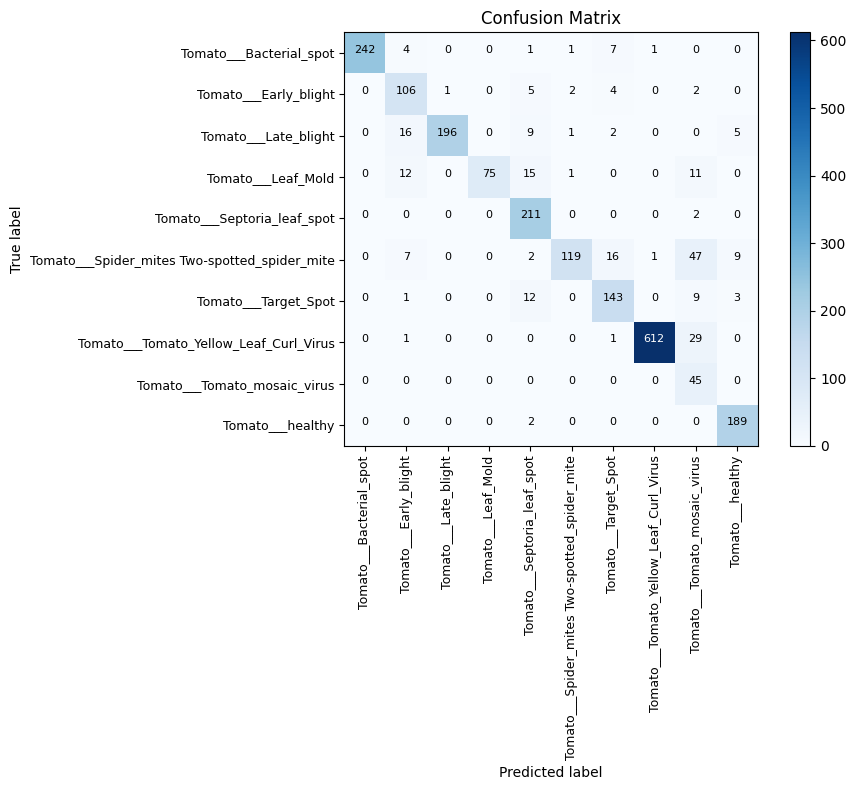

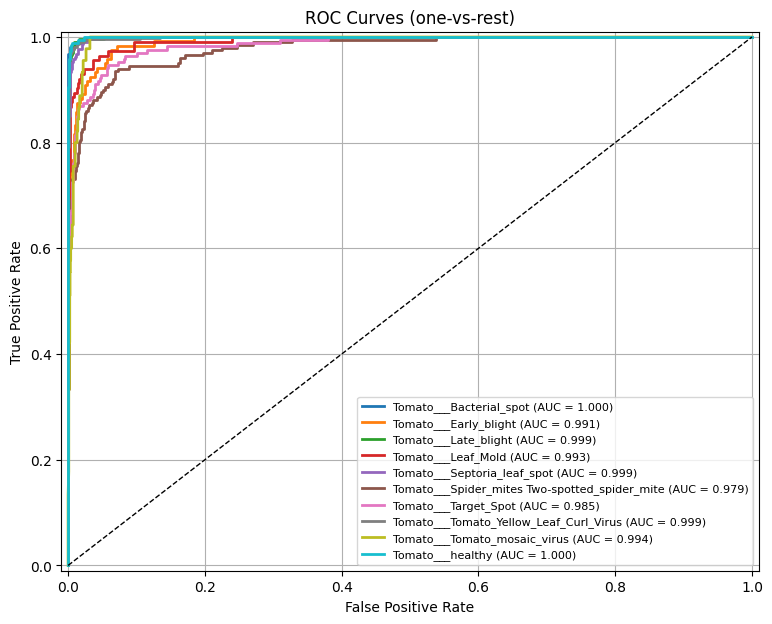

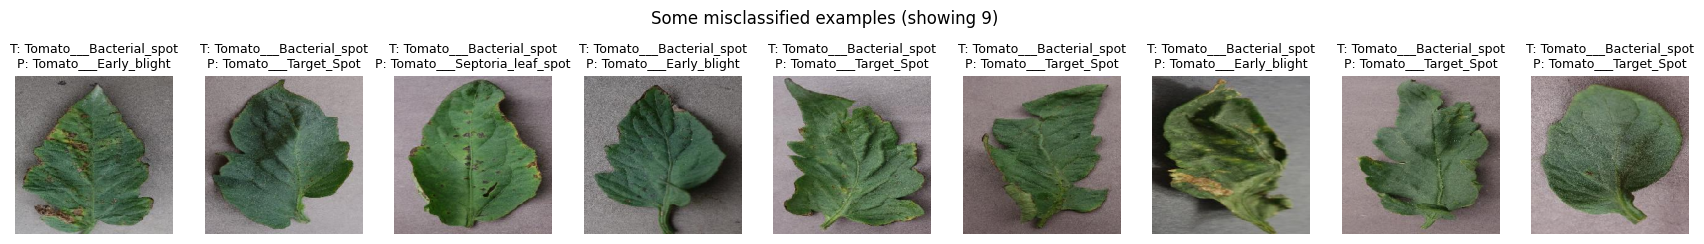


One predicted sample per class:


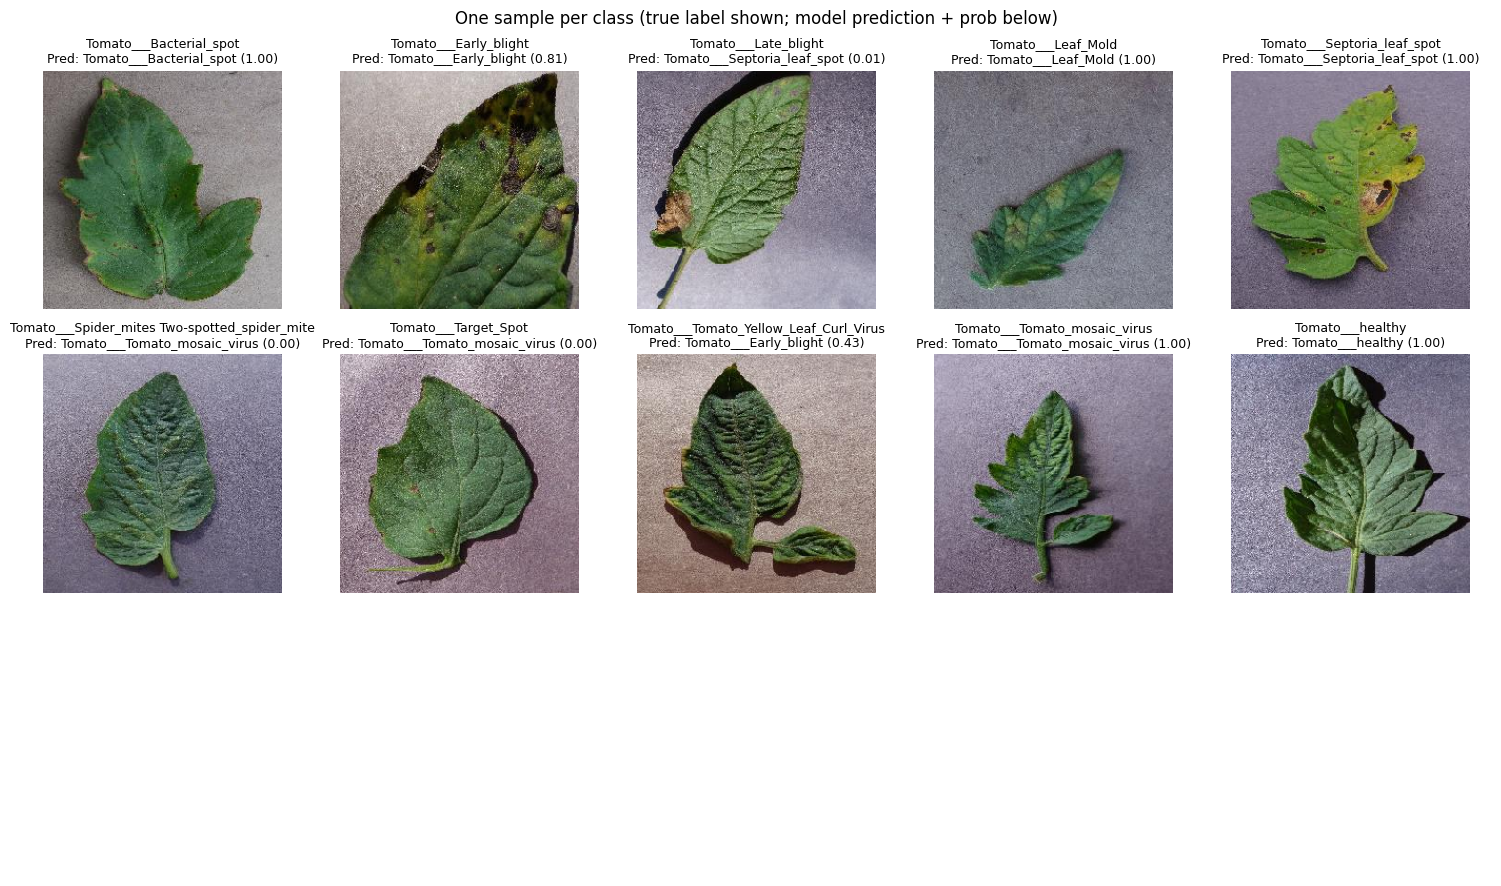

Saved classification report and arrays to: /kaggle/working/eval


In [ ]:
# Evaluation — classification report, confusion matrix, F1, ROC per-class,
#           show some misclassified images and show one predicted sample per class.
 
 

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# ----- Config (edit only if your paths differ) -----
TEST_DIR = "/kaggle/working/data/test"
TARGET_SIZE = (227, 227)
BATCH_SIZE = 64
BEST_PATHS = [
    "/kaggle/working/models/alexnet_optimized_best.h5",
    "/kaggle/working/models/alexnet_best.h5"
]
# pick the first existing model path
BEST_PATH = next((p for p in BEST_PATHS if Path(p).exists()), None)
if BEST_PATH is None:
    raise FileNotFoundError("Could not find saved model. Set BEST_PATH variable to your weights file.")

#  build file list and true labels in deterministic order -----
test_root = Path(TEST_DIR)
class_names = sorted([p.name for p in test_root.iterdir() if p.is_dir()])
class_to_idx = {c:i for i,c in enumerate(class_names)}

filepaths = []
y_true = []
for cls in class_names:
    cls_path = test_root / cls
    # sort filenames so order is deterministic
    for fp in sorted(cls_path.glob("*")):
        if fp.is_file():
            filepaths.append(str(fp))
            y_true.append(class_to_idx[cls])

y_true = np.array(y_true, dtype=np.int32)
n_samples = len(filepaths)
n_classes = len(class_names)
print(f"Found {n_samples} test images across {n_classes} classes.")

# ----- load model -----
model = tf.keras.models.load_model(BEST_PATH)
print("Loaded model:", BEST_PATH)

# ----- batch predict (safe memory) -----
def batch_predict(fpaths, batch_size=BATCH_SIZE):
    probs = []
    for i in range(0, len(fpaths), batch_size):
        batch_f = fpaths[i:i+batch_size]
        batch_imgs = []
        for fp in batch_f:
            img = load_img(fp, target_size=TARGET_SIZE)
            arr = img_to_array(img).astype("float32") / 255.0
            if arr.shape[-1] == 4:
                arr = arr[..., :3]
            batch_imgs.append(arr)
        batch_x = np.stack(batch_imgs, axis=0)
        p = model.predict(batch_x, verbose=0)
        probs.append(p)
    return np.vstack(probs)

y_proba = batch_predict(filepaths, batch_size=BATCH_SIZE)   
y_pred = np.argmax(y_proba, axis=1)

# ----- classification report & F1 -----
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
macro_f1 = f1_score(y_true, y_pred, average='macro')
micro_f1 = f1_score(y_true, y_pred, average='micro')

print("\n=== Classification Report ===\n")
print(report)
print(f"Macro F1: {macro_f1:.4f} | Micro F1: {micro_f1:.4f}")

# ----- confusion matrix (clean heatmap) -----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, class_names, rotation=90, fontsize=9)
plt.yticks(tick_marks, class_names, fontsize=9)
thresh = cm.max() / 2.
# annotate
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=8)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ----- ROC curves  
# Binarize true labels
y_true_bin = label_binarize(y_true, classes=range(n_classes))
if n_classes == 1:
    print("Only 1 class present — skipping ROC.")
else:
    plt.figure(figsize=(9,7))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{class_names[i]} (AUC = {roc_auc:.3f})")
    plt.plot([0,1],[0,1], 'k--', lw=1)
    plt.xlim([-0.01,1.01]); plt.ylim([-0.01,1.01])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (one-vs-rest)")
    plt.legend(loc="lower right", fontsize=8)
    plt.grid(True)
    plt.show()

# ----- show some misclassified images (up to 9) -----
mis_idx = np.where(y_true != y_pred)[0]
n_show = min(9, len(mis_idx))
if n_show == 0:
    print("No misclassified images found on test set.")
else:
    fig, axs = plt.subplots(1, n_show, figsize=(n_show*2.4,3))
    sel = mis_idx[:n_show]
    for ax, idx in zip(axs, sel):
        img = load_img(filepaths[idx], target_size=TARGET_SIZE)
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}", fontsize=9)
    plt.suptitle(f"Some misclassified examples (showing {n_show})")
    plt.show()

# ----- predict and display one sample per class  
print("\nOne predicted sample per class:")
fig, axs = plt.subplots(n_classes//5 + 1, 5, figsize=(15, 3*(n_classes//5 + 1)))
axs = axs.flatten()
shown = 0
for i, cls in enumerate(class_names):
    # find first sample of this class in filepaths
    try:
        idx = next(k for k,v in enumerate(y_true) if v == i)
    except StopIteration:
        continue
    img = load_img(filepaths[idx], target_size=TARGET_SIZE)
    axs[shown].imshow(img)
    axs[shown].axis('off')
    prob = y_proba[idx, i]
    pred_label = class_names[y_pred[idx]]
    axs[shown].set_title(f"{cls}\nPred: {pred_label} ({prob:.2f})", fontsize=9)
    shown += 1
# hide empty axes
for ax in axs[shown:]:
    ax.axis('off')
plt.suptitle("One sample per class (true label shown; model prediction + prob below)")
plt.tight_layout()
plt.show()

# ----- summary outputs saved to disk (optional) -----
out_dir = "/kaggle/working/eval"
os.makedirs(out_dir, exist_ok=True)
with open(os.path.join(out_dir, "classification_report.txt"), "w") as f:
    f.write(report)
np.save(os.path.join(out_dir, "y_true.npy"), y_true)
np.save(os.path.join(out_dir, "y_pred.npy"), y_pred)
print(f"Saved classification report and arrays to: {out_dir}")
